In [1]:
import json

# 存放解析后的 JSON 数据
data_list = []

with open('datasets/data.segment.json', 'r') as f:
    for line in f:
        data = json.loads(line)
        data_list.append(data)

# 打印读取到的数据
for item in data_list[:10]:
    print(item)

{'utt': 'Xhr3e5y_fvw-0', 'start': 0.0, 'end': 3.48, 'text': '<SIL>', 'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus', 'dur': 3.48}
{'utt': 'Xhr3e5y_fvw-1', 'start': 3.48, 'end': 7.33, 'text': '<SIL> ♪ OOH MMM ♪', 'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus', 'dur': 3.85}
{'utt': 'Xhr3e5y_fvw-2', 'start': 7.33, 'end': 10.61, 'text': '<SIL> ♪ YEAH ♪', 'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus', 'dur': 3.2799999999999994}
{'utt': 'Xhr3e5y_fvw-3', 'start': 10.61, 'end': 12.81, 'text': '♪ AY AY ♪', 'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus', 'dur': 2.200000000000001}
{'utt': 'Xhr3e5y_fvw-4', 'start': 12.81, 'end': 16.0, 'text': '♪ WAKE UP TO THE SUNLIGHT ♪ ♪ CREEPING THROUGH THE WINDOW ♪', 'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus', 'dur': 3.1899999999999995}
{'utt': 'Xhr3e5y_fvw-5', 'start'

In [2]:
len(data_list)

932773

In [4]:
for data in data_list:
    data['text'] = data['text'].replace('♪♪♪','♪').replace('♪♪','♪').replace('♪ ♪','♪').replace('♪ ♪','♪')
for data in data_list:
    data['text'] = data['text'].replace('♪♪♪','♪').replace('♪♪','♪').replace('♪ ♪','♪').replace('♪ ♪','♪')
clean_data = []
for data in data_list:
    if data['text'].count('♪') ==1 or data['text'].count('♪') ==0:
        continue
    clean_data.append(data)

In [5]:
import re 
def replace_middle_notes(input_str):
    input_str = input_str.strip()
    # 移除首部的<SIL>
    if input_str.startswith('<SIL>'):
        input_str = input_str[len('<SIL>'):]

    # 移除尾部的<SIL>
    if input_str.endswith('<SIL>'):
        input_str = input_str[:-len('<SIL>')]

    # 首先找到第一个和最后一个♪
    first_note = input_str.find('♪')
    last_note = input_str.rfind('♪')
    
    # 如果没有找到，或只有一个，直接返回原字符串
    if first_note == -1 or first_note == last_note:
        print(input_str)
    
    # 将中间部分分离出来
    middle = input_str[first_note+1:last_note]
    
    # 将中间部分的♪替换为，
    middle_replaced = re.sub('♪', ',', middle)
    
    # 重新组合字符串
    return input_str[:first_note+1] + middle_replaced + input_str[last_note:]

for data in clean_data:
    data['text'] = replace_middle_notes(data['text'])

In [7]:
# 清除开头的特殊符号
fuhao = ['-']
for data in clean_data:
    data['text'] = data['text'].strip()
    for fuhao in fuhao:
        if data['text'].startswith(fuhao):
            data['text'] = data['text'][len(fuhao):]
            data['text'] = data['text'].strip()

In [8]:
len(clean_data)

839213

In [9]:
vocal_data = []
cnt = 0
for data in clean_data:
    s = data['text']
    if not (s.startswith('♪') and s.endswith('♪')):
        continue
    vocal_data.append(data)

In [10]:
len(vocal_data)

833737

In [12]:
import os
from pathlib import Path
import numpy as np
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
def check_data(data):
    # print(data)
    result_path = os.path.join('/data4/leishun/processed_data/vocal_vad_result',data['utt']+'.npy')
    if not Path(result_path).exists():
        return None
    result = np.load(result_path)
    # print(result)
    s = result[0,0]/1000
    e = result[-1,-1]/1000
    # 确定真正的起点和终点
    data['start'] = data['start'] + max(0,s-0.1)
    data['end'] = min(data['start']+e+0.1,data['end'])
    data['dur'] = data['end'] - data['start']
    
    
    # 丢掉平均phone>2的
    text = data['text']
    text = text.replace('♪', '')
    cleaned_text = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}|\<.*?\>', '', text)
    cleaned_text = re.sub(r' +', ' ', cleaned_text)
    split_text = cleaned_text.strip().split(' ')
    cnt = 0
    for t in split_text:
        if t != '':
            cnt += 1
    if cnt == 0:
        return None
    if float(data['dur'])/cnt > 2:
        return None
    
    # 丢掉内部静音占比超过15%的
    duration = result[-1,-1] - result[0,0]
    cnt = 0
    for i in range(result.shape[0]):
        cnt += result[i,1]-result[i,0]
    rate = cnt/duration
    if rate<0.85:    
        return None
    # print(data)
    return data

# datas = []
# for data in vocal_data[:50]:
#     d = check_data(data)
#     if d is not None:
#         datas.append(d)
# print(len(datas))

print(len(vocal_data))
with Pool(processes=32) as pool:  # 创建一个包含4个进程的进程池
    datas = list(tqdm(pool.imap(check_data, vocal_data), total=len(vocal_data)))

clean_datas = []
for data in datas:
    if data is not None:
        clean_datas.append(data)
print(len(clean_datas))

833737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 833737/833737 [01:42<00:00, 8160.55it/s]


741917


In [13]:
clean_datas[:10]

[{'utt': 'Xhr3e5y_fvw-1',
  'start': 3.48,
  'end': 7.33,
  'text': '♪ OOH MMM ♪',
  'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus',
  'dur': 3.85},
 {'utt': 'Xhr3e5y_fvw-3',
  'start': 10.61,
  'end': 12.81,
  'text': '♪ AY AY ♪',
  'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus',
  'dur': 2.200000000000001},
 {'utt': 'Xhr3e5y_fvw-4',
  'start': 12.81,
  'end': 16.0,
  'text': '♪ WAKE UP TO THE SUNLIGHT , CREEPING THROUGH THE WINDOW ♪',
  'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus',
  'dur': 3.1899999999999995},
 {'utt': 'Xhr3e5y_fvw-5',
  'start': 16.0,
  'end': 17.72,
  'text': '♪ GLOWING ON YOUR BODY ♪',
  'wav': '/data4/music-corpus/yt-best/separated_opus/htdemucs/Xhr3e5y_fvw/vocals.opus',
  'dur': 1.7199999999999989},
 {'utt': 'Xhr3e5y_fvw-6',
  'start': 17.72,
  'end': 22.69,
  'text': "♪ CAN WE KEEP IT SIMPLE , I NEED MORE THAN ONE NIGHT , WHAT YOU THINK I'M HERE 

In [14]:
def get_segment(name,idx,start,end,text_list,wav,dur):
    segment = {}
    segment['utt'] = name + '-' + str(idx)
    segment['start'] = start
    segment['end'] = end
    segment['text'] = ' '.join(text_list)
    segment['wav'] = wav
    segment['dur'] = dur
    return segment

In [15]:
music_data = {}

for data in clean_datas:
    name = '-'.join(data['utt'].split('-')[:-1])
    if name not in music_data:
        music_data[name] = []
    music_data[name].append(data)
len(music_data)

25654

In [28]:
max_duration = 15.0
segments = []
for name in music_data.keys():
    music = music_data[name]
    cnt = 0
    st = music[0]['start']
    ed = music[0]['start']
    text = []
    wav = music[0]['wav']
    duration = 0
    for data in music:
        start = data['start']
        end = data['end']
        if (end - start) + duration > max_duration:
            if duration > 0:
                segments.append(get_segment(name,cnt,st,ed,text,wav,duration))
                st = start
                ed = start
                text = []
                cnt += 1
                duration = 0
            else:
                st = start
                ed = start
                text = []
                duration = 0
                
        if start - ed > 0.5:
            if duration > 0:
                segments.append(get_segment(name,cnt,st,ed,text,wav,duration))
                st = start
                ed = start
                text = []
                cnt += 1
                duration = 0
            else:
                st = start
                ed = start
                text = []
                duration = 0
                
        
        if end - start > max_duration:
            segments.append(get_segment(name,cnt,start,start+max_duration,[data['text']],wav,max_duration))
            st = end
            ed = end
            text = []
            cnt += 1
            duration = 0
        else:
            if duration == 0:
                st = start
                ed = end
                text.append(data['text'])
                duration += (end-start)
            else:
                st = st
                ed = end
                text.append(data['text'])
                duration += (end-start)
            
    if duration > 1.0:
        segments.append(get_segment(name,cnt,st,ed,text,wav,duration))

In [29]:
len(segments)

368633

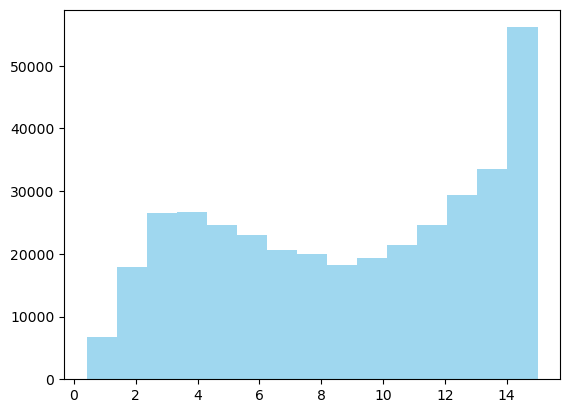

In [30]:
import matplotlib.pyplot as plt
import numpy as np
time = []
for segment in segments:
    time.append(segment['dur'])

# 生成一组随机数据
time = np.array(time)

# 绘制直方图
plt.hist(time, bins=15, color='skyblue', alpha=0.8)


# 显示图表
plt.show()